In [2]:
# Importing Libraries and Dataset

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
from scipy.stats import zscore
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
# Load dataset
df = pd.read_csv(r'C:\Users\aevag\Desktop\IPYNB\german_credit_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [5]:
# Drop the "Unnamed: 0" column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# We will now convert the categorical data to numerical data.
df['Sex'] = df['Sex'].map({'male': 1, 'female': 2})
df['Housing'] = df['Housing'].map({'own': 1, 'rent': 2, 'free': 3})
df['Purpose'] = df['Purpose'].map({'car': 1, 'furniture/equipment': 2, 'radio/TV': 3, 'domestic appliances': 4, 'repairs': 5, 'education': 6, 'business': 7, 'vacation/others': 8})
checking_account_map = {'little': 1, 'moderate': 2, 'rich': 3}
savings_account_map = {'little': 1,'moderate': 2,'quite rich': 3,'rich': 4}
df['Saving accounts'] = df['Saving accounts'].map(savings_account_map)
df['Checking account'] = df['Checking account'].map(checking_account_map)

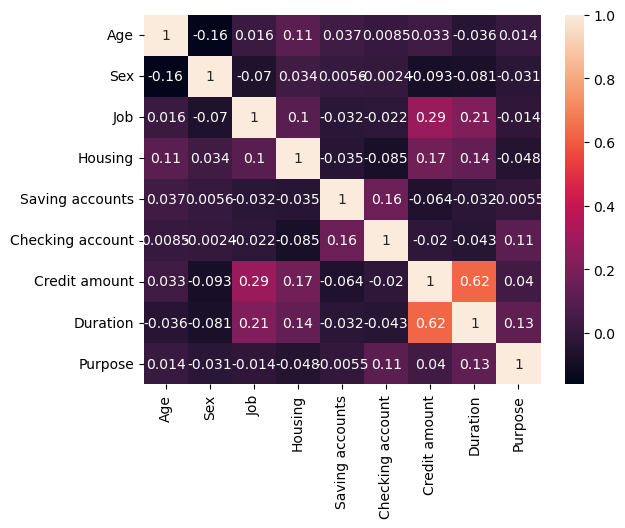

In [7]:
# Plot the correlation heatmap
sns.heatmap(df.corr(), annot=True)
plt.show()

In [8]:
# Define risk
median_credit = df['Credit amount'].median()
df['Risk'] = np.where(df['Credit amount'] < median_credit, 0, 1)

In [9]:
# Check for missing values
print(df.isnull().sum())

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [10]:
df.describe()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,817.000000,606.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,35.546000,1.310000,1.904000,1.395000,1.456548,1.651815,3271.258000,20.903000,2.826000,0.50000
std,11.375469,0.462725,0.653614,0.674856,0.869350,0.659994,2822.736876,12.058814,1.996424,0.50025
min,19.000000,1.000000,0.000000,1.000000,1.000000,1.000000,250.000000,4.000000,1.000000,0.00000
25%,27.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1365.500000,12.000000,1.000000,0.00000
50%,33.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2319.500000,18.000000,2.000000,0.50000
75%,42.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3972.250000,24.000000,3.000000,1.00000
max,75.000000,2.000000,3.000000,3.000000,4.000000,3.000000,18424.000000,72.000000,8.000000,1.00000


In [11]:
# Replace missing values in "Saving accounts" column with mode
mode_saving_accounts = df['Saving accounts'].mode()[0]
df['Saving accounts'].fillna(mode_saving_accounts, inplace=True)

# Replace missing values in "Checking account" column with median
median_checking_account = df['Checking account'].median()
df['Checking account'].fillna(median_checking_account, inplace=True)

# Verify if there are still any missing values
print(df.isnull().sum())

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64


In [12]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,1.0,1.0,1169,6,3,0
1,22,2,2,1,1.0,2.0,5951,48,3,1
2,49,1,1,1,1.0,2.0,2096,12,6,0
3,45,1,2,3,1.0,1.0,7882,42,2,1
4,53,1,2,3,1.0,1.0,4870,24,1,1


In [13]:
# Calculate z-scores for all columns except Job and Purpose
z_scores = zscore(df[['Age', 'Sex', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']])

# Identify outliers with z-score > 3
outliers = (z_scores > 3).any(axis=1)

# Print number of outliers
print('Number of outliers:', outliers.sum())

Number of outliers: 90


In [14]:
# Remove any outliers
df = df[~outliers]

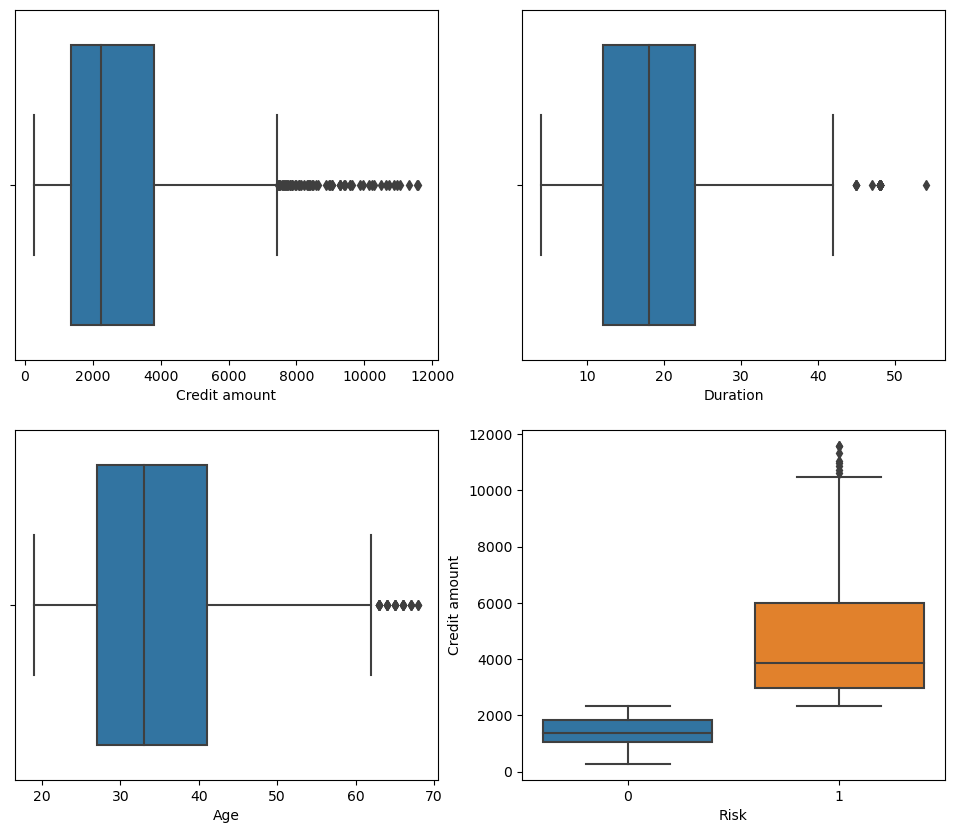

In [15]:
# Check for outliers in Credit amount, Duration, Age, and Risk
# Four boxplots: one for Credit amount, one for Duration, one for Age, and one for Risk (with Credit amount on the y-axis). The Risk boxplot will have two boxes, one for good credit risks and one for bad credit risks, to show the distribution of Credit amount for each group.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
sns.boxplot(x='Credit amount', hue='Risk', data=df, ax=axes[0][0])
sns.boxplot(x='Duration', hue='Risk', data=df, ax=axes[0][1])
sns.boxplot(x='Age', hue='Risk', data=df, ax=axes[1][0])
sns.boxplot(x='Risk', y='Credit amount', data=df, ax=axes[1][1])
plt.show()

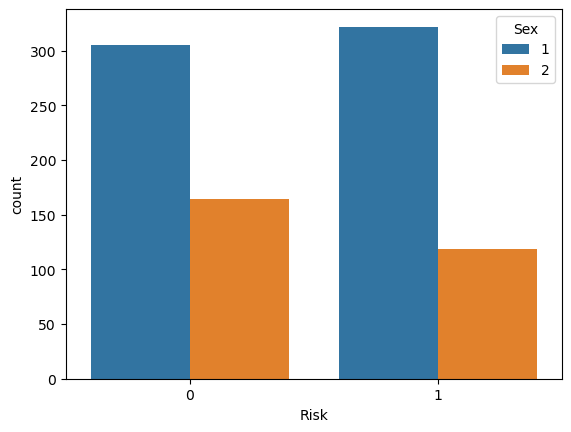

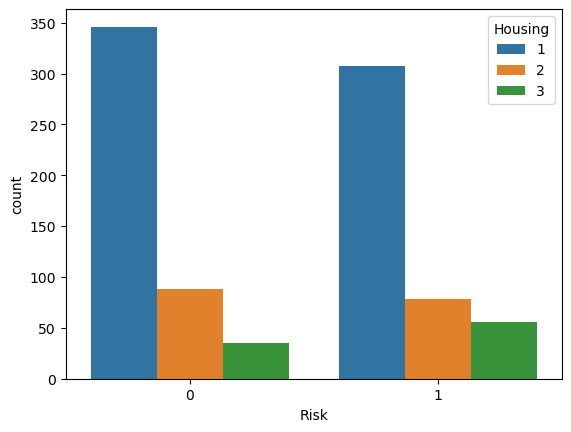

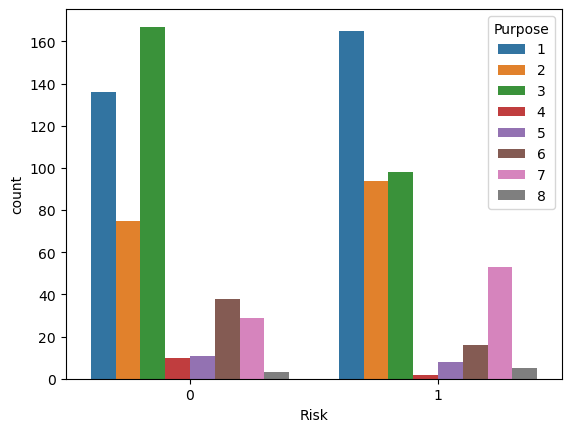

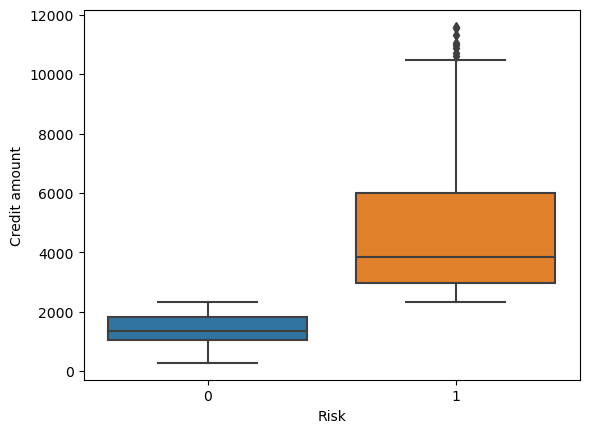

<AxesSubplot:xlabel='Risk', ylabel='Duration'>

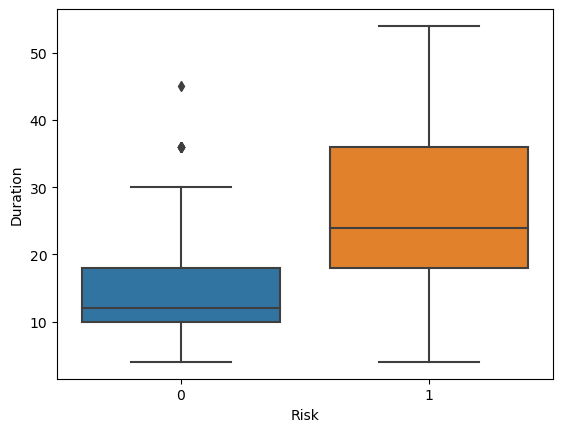

In [16]:
# Distribution of credit risk by gender
sns.countplot(x='Risk', hue='Sex', data=df)
plt.show()

# Distribution of credit risk by housing type
sns.countplot(x='Risk', hue='Housing', data=df)
plt.show()

# Distribution of credit risk by purpose
sns.countplot(x='Risk', hue='Purpose', data=df)
plt.show()

# Distribution of credit amount by risk
sns.boxplot(x='Risk', y='Credit amount', data=df)
plt.show()

# Distribution of duration by risk
sns.boxplot(x='Risk', y='Duration', data=df)

In [17]:
# Replace outliers with median
median_credit = df['Credit amount'].median()
iqr_credit = np.percentile(df['Credit amount'], 75) - np.percentile(df['Credit amount'], 25)
upper_credit = np.percentile(df['Credit amount'], 75) + 1.5 * iqr_credit
df.loc[df['Credit amount'] > upper_credit, 'Credit amount'] = median_credit

median_duration = df['Duration'].median()
iqr_duration = np.percentile(df['Duration'], 75) - np.percentile(df['Duration'], 25)
upper_duration = np.percentile(df['Duration'], 75) + 1.5 * iqr_duration
df.loc[df['Duration'] > upper_duration, 'Duration'] = median_duration

median_age = df['Age'].median()
iqr_age = np.percentile(df['Age'], 75) - np.percentile(df['Age'], 25)
upper_age = np.percentile(df['Age'], 75) + 1.5 * iqr_age
df.loc[df['Age'] > upper_age, 'Age'] = median_age

In [18]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,33,1,2,1,1.0,1.0,1169,6,3,0
1,22,2,2,1,1.0,2.0,5951,18,3,1
2,49,1,1,1,1.0,2.0,2096,12,6,0
3,45,1,2,3,1.0,1.0,2250,42,2,1
4,53,1,2,3,1.0,1.0,4870,24,1,1


In [19]:
# Perform hypothesis testing between the credit amounts of good and bad credit risks
good_credit = df[df['Risk'] == 0]['Credit amount']
bad_credit = df[df['Risk'] == 1]['Credit amount']
t_stat, p_val = ttest_ind(good_credit, bad_credit, equal_var=False)

print('T-test results:')
print('t-statistic =', t_stat)
print('p-value =', p_val)

T-test results:
t-statistic = -32.990967994402915
p-value = 1.6932593434388276e-131


In [20]:
# Based on the t-test results, we can see that there is a significant difference between the credit amounts of good and bad credit risks, as the t-statistic is quite large and the p-value is very small (less than 0.05).
# This indicates that we can reject the null hypothesis that the means of the two groups are equal and conclude that the credit amount is a significant predictor of credit risk.

In [21]:
# Perform t-test to compare mean age of good and bad credit risks
age_good_risk = df[df['Risk']== 0]['Age']
age_bad_risk = df[df['Risk']== 1]['Age']
t_statistic, p_value = stats.ttest_ind(age_good_risk, age_bad_risk)
print("t-statistic:", t_statistic, "p-value:", p_value)
# The p-value is the probability of observing a t-statistic as extreme or more extreme than the one observed, assuming that the null hypothesis is true. In this case, the p-value is 0.884, which is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis and conclude that there is not enough evidence to support the claim that the mean age of good credit risks is different from the mean age of bad credit risks.

t-statistic: -0.1455287546977746 p-value: 0.8843257131459866


In [22]:
# Perform data scaling on the numeric columns
numeric_cols = ['Age', 'Job', 'Credit amount', 'Duration']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [23]:
print('Scaled dataset:')
print(df.head())

Scaled dataset:
        Age  Sex       Job  Housing  Saving accounts  Checking account  \
0 -0.123030    1  0.179771        1              1.0               1.0   
1 -1.281576    2  0.179771        1              1.0               2.0   
2  1.562127    1 -1.378245        1              1.0               2.0   
3  1.140837    1  0.179771        3              1.0               1.0   
4  1.983416    1  0.179771        3              1.0               1.0   

   Credit amount  Duration  Purpose  Risk  
0      -0.866979 -1.425954        3     0  
1       2.159889 -0.070385        3     1  
2      -0.280215 -0.748170        6     0  
3      -0.182737  2.640752        2     1  
4       1.475647  0.607399        1     1  


In [24]:
# Perform data scaling on 'Credit amount' and 'Duration' columns using StandardScaler
scaler = StandardScaler()
df[['Credit amount', 'Duration']] = scaler.fit_transform(df[['Credit amount', 'Duration']])

In [25]:
# Split the data into training and testing sets
X = df.drop('Risk', axis=1)
y = df['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [27]:
# Fit the random forest model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [28]:
# Fit the XGBoost model
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
# Evaluate the models
print("Logistic Regression Accuracy:", log_reg.score(X_test, y_test))
print("Random Forest Accuracy:", rfc.score(X_test, y_test))
print("XGBoost Accuracy:", xgbc.score(X_test, y_test))

Logistic Regression Accuracy: 0.9340659340659341
Random Forest Accuracy: 0.9835164835164835
XGBoost Accuracy: 0.9945054945054945


In [30]:
# Conclusion
print("\nBased on the accuracy scores, XGBoost performed the best.")


Based on the accuracy scores, XGBoost performed the best.


In [31]:
# Exporting
df.to_excel('final_output.xlsx', index=False)